# Predicting Popular Recipes for Homepage Display

## Introduction

In our ongoing efforts to enhance user engagement and improve the overall user experience on our website, we recognize the need for a more systematic and data-driven approach to selecting recipes for display on the homepage. The current methodology, which relies on individual preferences, has proven inconsistent in delivering content that resonates with our diverse audience.

To address this challenge, we have embraced the power of machine learning through the implementation of advanced binary classification models, specifically utilizing Random Forest and Logistic Regression algorithms. These models are designed to predict whether a recipe is likely to generate high or low levels of traffic based on various features and historical data.

This shift towards a data-driven recipe selection process not only introduces a more strategic and reliable method but also aligns with our broader objective of tailoring our content to meet the varied preferences of our users. Our goal is to create a homepage that not only attracts visitors but also encourages prolonged engagement and increased subscriptions.

This notebook provides an in-depth exploration of our methodology, details on model implementation, and showcases the promising results obtained from these predictive models. Through this innovative approach, we aim to optimize our homepage content, ultimately driving higher traffic and fostering a more satisfying user experience.

## Data Preprocessing
During the data preprocessing phase, we validate our dataset to ensure its suitability for training binary classification models. We address missing values through appropriate techniques, such as imputation or removal, preserving data integrity. The target variable, representing 'High Traffic' or 'Low Traffic,' is defined from historical traffic data. Outliers in numerical features are identified and addressed using established techniques like the Interquartile Range (IQR) to prevent undue influence on model performance. These preprocessing steps collectively refine our dataset, laying a solid foundation for subsequent model training and evaluation.

In [84]:
# Importing necessary libraries
import numpy as np
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# Reading the data
df = pd.read_csv('receipe_data.csv', index_col='recipe')
print(df.shape)
df.head()

(947, 7)


,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      947 non-null    object 
 5   servings      947 non-null    object 
 6   high_traffic  574 non-null    object 
dtypes: float64(4), object(3)
memory usage: 59.2+ KB


 ###  Variable: Category
 The variable category is changed into the category. The categories 'Chicken Breast' and 'Chicken' have been consolidated into a unified category labeled 'chicken.

In [87]:
df['category'] = df['category'].astype('category')
print(df["category"].value_counts())
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Dessert            83
Vegetable          83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


### Variable: high_traffic
The variable "high_traffic" has been converted into a categorical variable. Any missing values (NaN) within the "high_traffic" variable have been replaced with the category "Low." Furthermore, the variable has been renamed to "traffic" for clarity.

In [88]:
# Print the original value counts
df['high_traffic'] = df['high_traffic'].astype('category')
print(df['high_traffic'].value_counts())

# Add a new category 'Low' and fill missing values
df['high_traffic'] = df['high_traffic'].cat.add_categories('Low')
df['high_traffic'] = df['high_traffic'].fillna('Low')

# Rename the column to 'traffic'
df.rename(columns={'high_traffic': 'traffic'}, inplace=True)

# Print the updated value counts
print(df['traffic'].value_counts())

High    574
Name: high_traffic, dtype: int64
High    574
Low     373
Name: traffic, dtype: int64


### Variable: Servings
The variable 'servings' was refined by removing the text " as a snack" from each entry, followed by converting the 'servings' column into a categorical type. The updated value counts is printed to observe the changes in the distribution after the data transformation.

In [89]:
# Print the original value counts
print(df['servings'].value_counts())

# Remove " as a snack" from the 'servings' column
df['servings'] = df['servings'].str.replace(' as a snack', '')

# Convert the 'servings' column to the categorical type
df['servings'] = df['servings'].astype('category')

# Print the updated value counts
print(df['servings'].value_counts())
df.shape

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64
4    391
6    198
2    183
1    175
Name: servings, dtype: int64


(947, 7)

### Duplicate Observation
The operation to drop duplicates from the DataFrame resulted in a reduction in the number of rows from 947 to 922. This indicates that there were 25 duplicate rows present in the original DataFrame, and after removal, the DataFrame now contains 922 unique rows. Removing duplicate values contributes the data integrity, consistency and accuracy.

In [90]:
# Drop duplicates
df.drop_duplicates(inplace= True)
df.shape

(922, 7)

### Dealing with missing values 
The dataset initially contained 922 observations, but after removing the 27 observations with missing values in the 'carbohydrate,' 'protein,' 'sugar,' and 'calories' variables, the dataset size has been reduced to 895. This process ensures a cleaner dataset for analysis.

In [91]:
# Handling missing values
print(df.isna().sum().sort_values())

category         0
servings         0
traffic          0
calories        27
carbohydrate    27
sugar           27
protein         27
dtype: int64


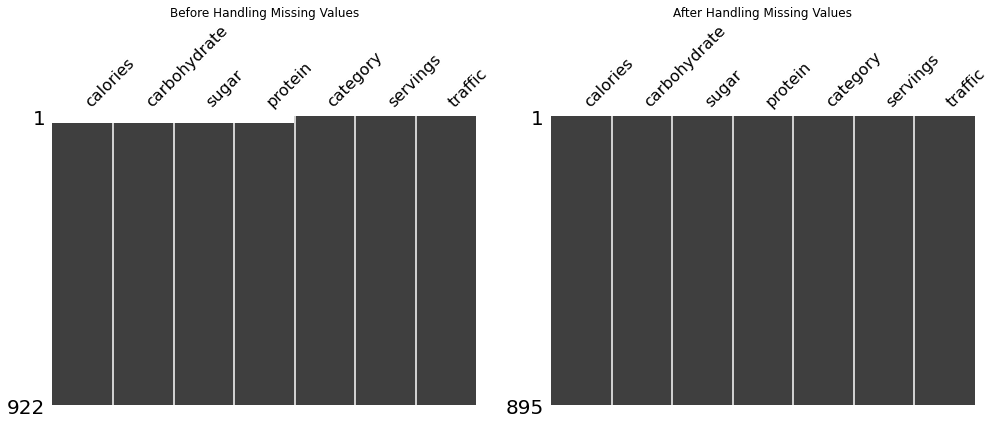

In [92]:
# Assuming you have already imported necessary libraries
import missingno as msno
# Create a copy of the original data
df_orig = df.copy()

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plotting missing values before handling
msno.matrix(df_orig, ax=axes[0], sort="ascending", sparkline=False)
axes[0].set_title("Before Handling Missing Values")

# Drop rows with missing values in specified columns
df = df.dropna(subset=['calories', 'carbohydrate', 'sugar', 'protein'])

# Plotting missing values after handling
msno.matrix(df, ax=axes[1], sort="ascending", sparkline=False)
axes[1].set_title("After Handling Missing Values")

plt.tight_layout()
plt.show()

### Dealing with outliers
The outliers in the numerical column of the dataset are handeled using the IQR method.  The function handle_outlier calculates the upper and lower bounds based on the IQR and replaces values outside this range with the respective bounds. 
Finally, a side-by-side box plot comparison is created to visually showcase the distribution of numerical values before and after outlier handling. The left plot represents the original data, while the right plot displays the data after outlier treatment.   It's evident that all values exhibit a right-skewed distribution.



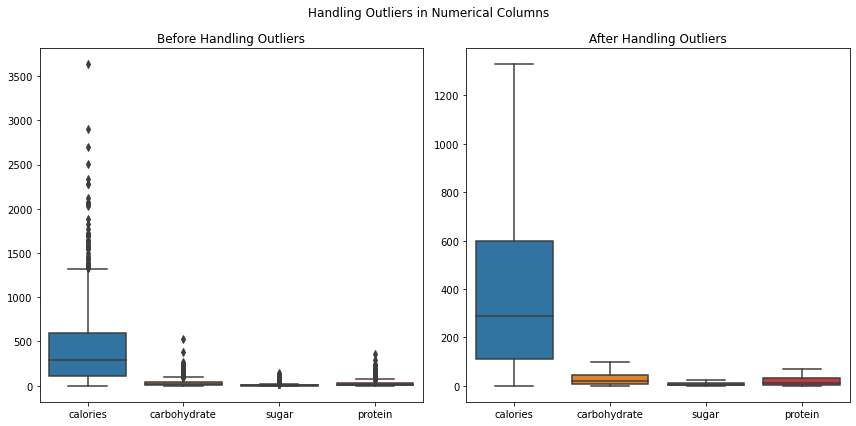

In [93]:
# Create a copy of the original data
df_original = df.copy()

# Handling Outliers
def handle_outlier(df, col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

# Select numerical columns
df_num = df.select_dtypes(include=["float64", "int64"])

# Handling outliers in numerical columns
for column in df_num.columns:
    handle_outlier(df, column)

# Visualizing outliers before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=df_original, ax=axes[0])
axes[0].set_title("Before Handling Outliers")

sns.boxplot(data=df, ax=axes[1])
axes[1].set_title("After Handling Outliers")

fig.suptitle("Handling Outliers in Numerical Columns")
plt.tight_layout()
plt.show()

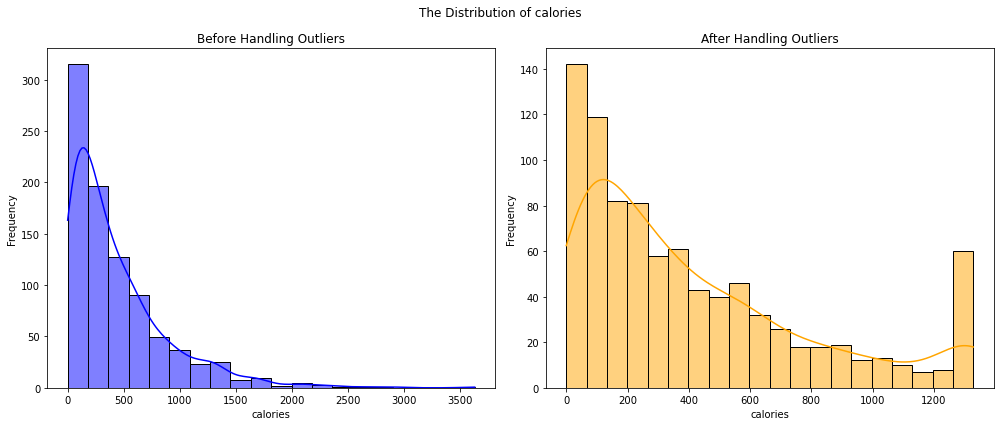

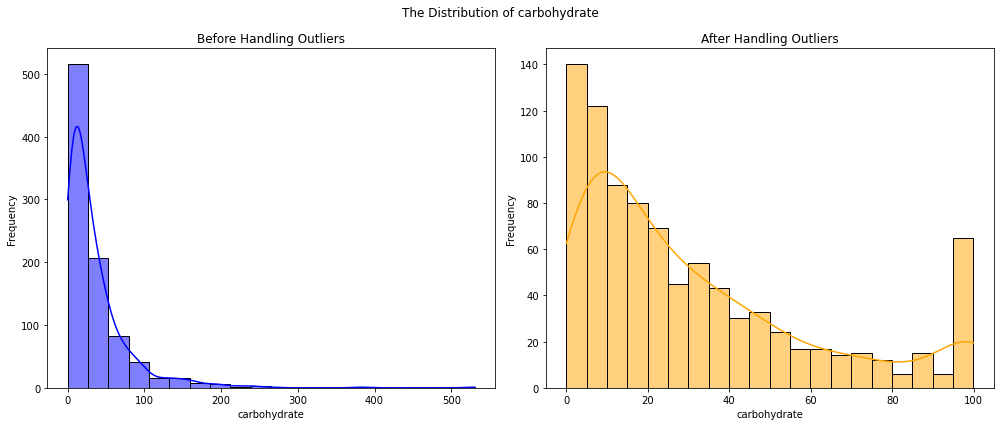

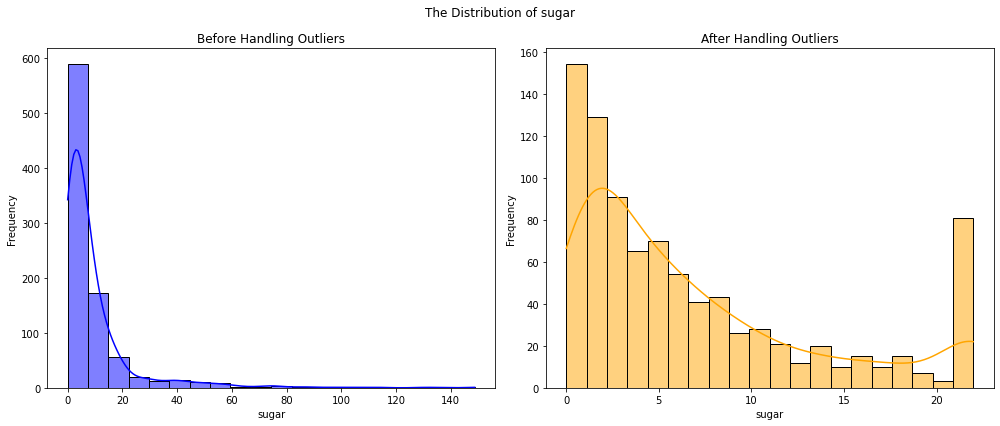

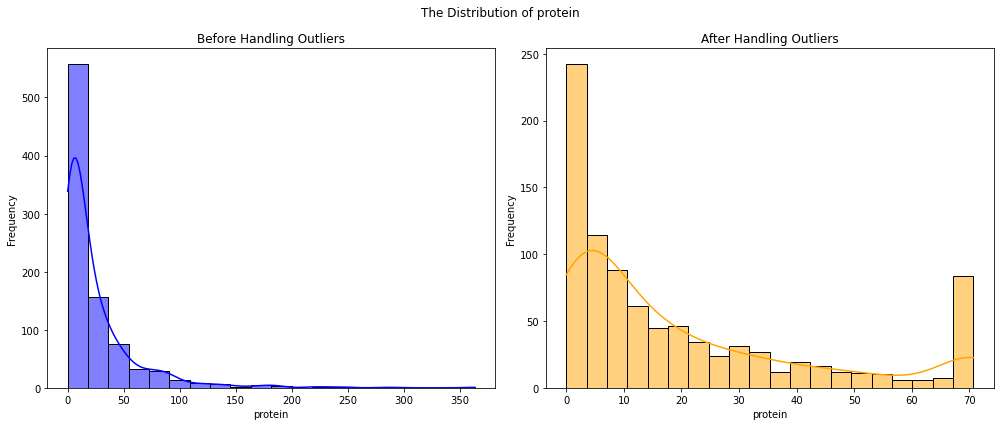

In [94]:
# Visualizing distributions before and after handling outliers
for col in df_num.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Before handling outliers
    sns.histplot(df_original[col], kde=True, color='blue', ax=axes[0], bins=20)
    axes[0].set_title("Before Handling Outliers")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")
    
    # After handling outliers
    sns.histplot(df[col], kde=True, color='orange', ax=axes[1], bins=20)
    axes[1].set_title("After Handling Outliers")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency")
    
    fig.suptitle('The Distribution of '+col)
    plt.tight_layout()
    plt.show()

## Explanatory Data Analysis

In [95]:
df.head(10)

,calories,carbohydrate,sugar,protein,category,servings,traffic
recipe,,,,,,,
2,35.48,38.56,0.660,0.9200,Potato,4,High
3,914.28,42.68,3.090,2.8800,Breakfast,1,Low
4,97.03,30.56,21.965,0.0200,Beverages,4,High
5,27.05,1.85,0.800,0.5300,Beverages,4,Low
6,691.15,3.46,1.650,53.9300,One Dish Meal,2,High
7,183.94,47.95,9.750,46.7100,Chicken,4,Low
8,299.14,3.17,0.400,32.4000,Lunch/Snacks,4,Low
9,538.52,3.78,3.370,3.7900,Pork,6,High
10,248.28,48.54,3.990,70.7075,Chicken,2,Low


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 2 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      895 non-null    category
 5   servings      895 non-null    category
 6   traffic       895 non-null    category
dtypes: category(3), float64(4)
memory usage: 38.3 KB


After processing, we now have clean data ready for exploration and analysis. The dataset contains 895 rows and 7 columns. The statistica are given as below.

In [97]:
df.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,413.361665,31.083430,6.834866,20.124053
std,378.241095,28.945415,6.624471,22.111812
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,1328.480000,99.850000,21.965000,70.707500


#### Target variable: traffic
The chart below displays the distribution of 'High' and 'Low' categories in this variable, revealing an unbalanced dataset, with 59.78% of the data belonging to the 'High' class and 40.22% to the 'Low' class

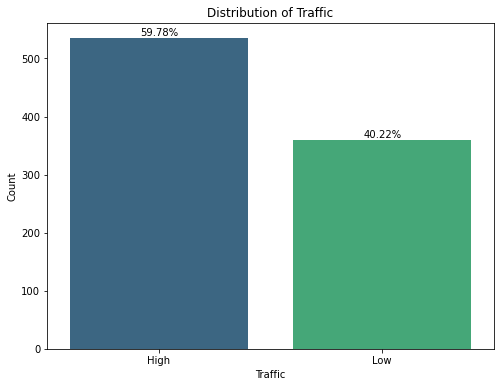

In [98]:
# Count plot for 'traffic'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='traffic', palette='viridis')

# Display percentage values on top of each bar
value_counts = df['traffic'].value_counts()
total_count = value_counts.sum()

for i, count in enumerate(value_counts):
    percentage = (count / total_count) * 100
    plt.text(i, count + 1, f"{percentage:.2f}%", ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Traffic')
plt.xlabel('Traffic')
plt.ylabel('Count')

plt.show()

#### Numerica variables 
From the heatmap below, we can conclude that there is a positive relationship between protien and calories, a negative relationship between protien and sugar.

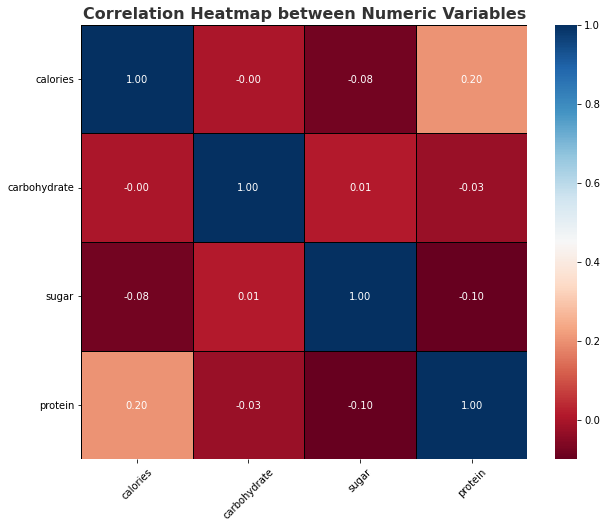

In [99]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

# Drop non-numeric columns
df_non_num = df.drop(columns=non_numeric_columns)

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(df_non_num.corr(), annot=True, fmt=".2f", linewidths=0.5, cmap="RdBu", linecolor="black")

# Enhance the heatmap appearance
heatmap.set_title("Correlation Heatmap between Numeric Variables", fontsize=16, fontweight='bold', color='#333333')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

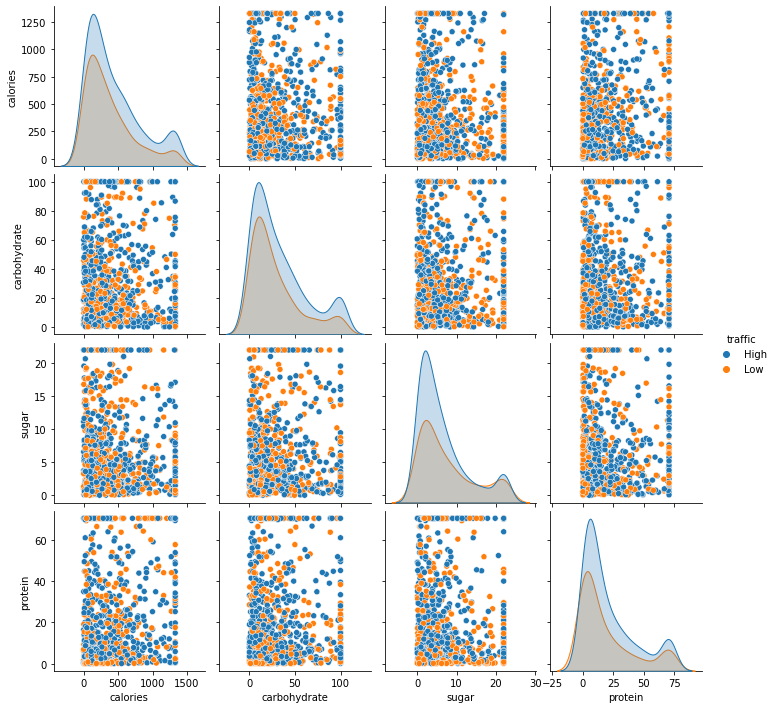

In [100]:
pair_plot = sns.pairplot(data=df, hue="traffic")
plt.show()

#### Relationship between the numeric variables and Target variable.
To explore the relationship between the target variable "traffic" and numerical features such as calories, carbohydrate, sugar, and protein, bar plots were created. Notably, the 'high' traffic category demonstrates elevated levels of calories, carbohydrate, and protein in contrast to the 'low' traffic category. Conversely, the sugar content tends to be lower in the 'high' traffic category, potentially reflecting a preference for less sweetness in foods among individuals in this traffic segment.

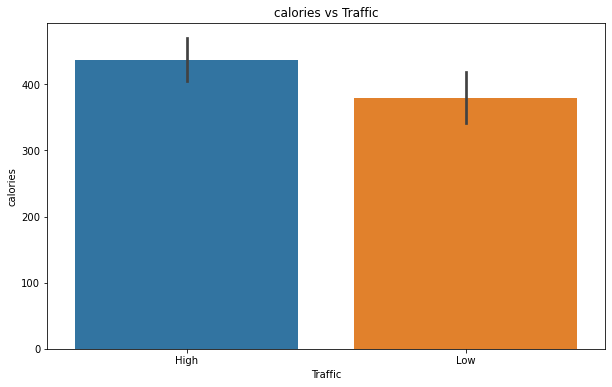

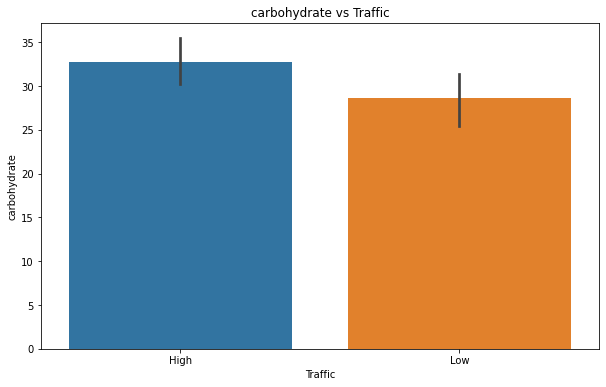

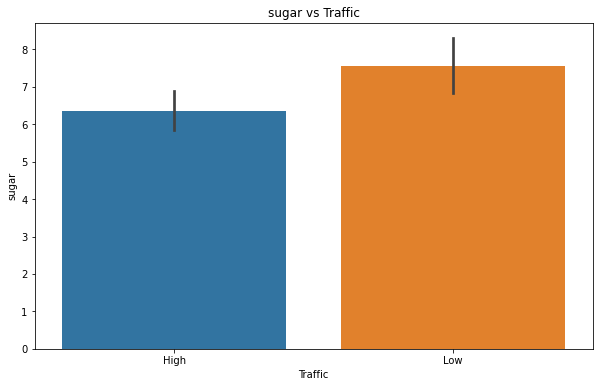

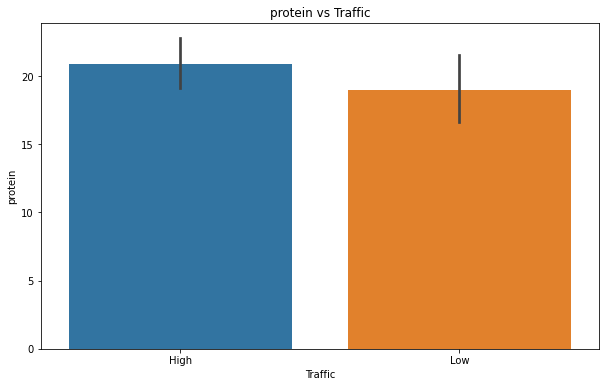

In [101]:
# Select numeric columns
data_num = df.select_dtypes(include=["float64", "int64"])

# Loop through numeric columns and create bar plots
for col in data_num.columns:
    plt.figure(figsize=(10, 6))
    
    # Bar plot
    bar = sns.barplot(data=df, x='traffic', y=col)
    
    # Set labels and title
    plt.xlabel('Traffic')
    plt.ylabel(col)
    plt.title(f'{col} vs Traffic')
    
    plt.show()

#### Categorical variables: Category and Servings
The bar chart clearly highlights that 'Chicken' and 'Breakfast' is the predominant recipe category, and a serving number of 4 is the most frequently observed.

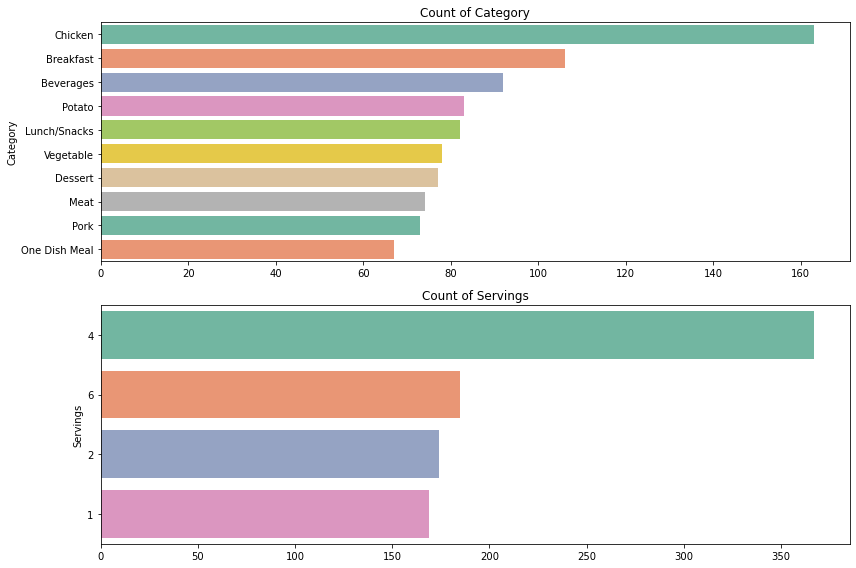

In [102]:
# Select columns for count plots
count_plot_columns = ['category', 'servings']

# Set the figure size
plt.figure(figsize=(12, 8))

# Loop through columns and create count plots
for i, col in enumerate(count_plot_columns, 1):
    plt.subplot(len(count_plot_columns), 1, i)
    if df[col].dtype.name == 'category':
        sns.countplot(y=col, data=df, palette="Set2", order=df[col].value_counts().index)
    else:
        sns.countplot(x=col, data=df, palette="viridis")
    plt.title(f'Count of {col.capitalize()}')
    plt.xlabel('Count' if df[col].dtype.name != 'category' else '')
    plt.ylabel(col.capitalize())
    if df[col].dtype.name != 'category':
        plt.xticks(rotation=45, ha='right')  

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

#### Relationship between categorical variable and target variable
The chart illustrates the relationships among traffic, category, and the number of servings. Significantly, a robust correlation is apparent between the traffic and category variables, with one tending to be high when the other is low and vice versa within recipe categories. Regarding the distribution between traffic and the number of servings, the 'high' class consistently emerges as the predominant category.

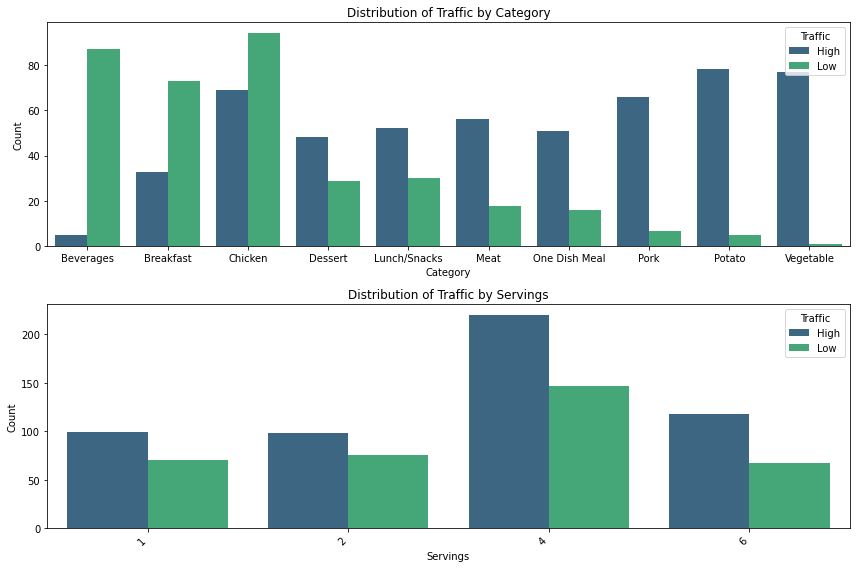

In [103]:
# Select columns for count plots
count_plot_columns = ['category', 'servings']

# Set the figure size
plt.figure(figsize=(12, 8))

# Loop through columns and create count plots with 'traffic' hue
for i, col in enumerate(count_plot_columns, 1):
    plt.subplot(len(count_plot_columns), 1, i)
    
    cou = sns.countplot(data=df, x=col, hue="traffic", palette="viridis")
    
    # Set titles and labels
    plt.title(f'Distribution of Traffic by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.legend(title='Traffic', loc='upper right')
    
    # Rotate x-axis labels for better readability
    if col == 'servings':
        plt.xticks(rotation=45, ha='right')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Model Development 
Addressing the binary classification challenge of predicting high traffic levels, I have chosen the Logistic Regression model as our primary method due to its simplicity and interpretability. Logistic Regression is particularly suitable for binary outcomes.

To provide a comparative analysis, I have also embraced the Random Forest model. Recognized for its ensemble learning capability, Random Forest combines multiple decision trees, delivering enhanced accuracy and resilience against overfitting when compared to individual Decision Tree classifiers. This dual-model approach aims to leverage the strengths of both Logistic Regression and Random Forest for a more comprehensive and robust prediction framework.

In [118]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df.head()

,calories,carbohydrate,sugar,protein,servings,traffic,category_Beverages,category_Breakfast,category_Chicken,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,std
recipe,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.660,0.92,4,0,0,0,0,0,0,0,0,0,1,0,18.147933
3,914.28,42.68,3.090,2.88,1,1,0,1,0,0,0,0,0,0,0,0,389.210353
4,97.03,30.56,21.965,0.02,4,0,1,0,0,0,0,0,0,0,0,0,36.187104
5,27.05,1.85,0.800,0.53,4,1,1,0,0,0,0,0,0,0,0,0,11.264798
6,691.15,3.46,1.650,53.93,2,0,0,0,0,0,0,0,1,0,0,0,291.511236


For modeling, I selected features (calories, carbohydrate, sugar, protein, servings, category) with traffic as the target variable. Categorical features were encoded, numeric features were scaled, and the dataset (895 rows, 18 columns) was split into training and test sets for unbiased model evaluation. Additionally, a standard deviation column was added to enhance performance.

In [105]:
# One-hot encoding for 'category' column
df = pd.get_dummies(df, columns=['category'])

# Convert 'servings' to integer
df['servings'] = df['servings'].astype('int')

# Label encode 'traffic' column
label_encoder = LabelEncoder()
df['traffic'] = label_encoder.fit_transform(df['traffic'])

# Calculate standard deviation for selected columns and add a new 'std' column
columns_to_std = ['calories', 'carbohydrate', 'sugar', 'protein']
df['std'] = df[columns_to_std].apply(np.std, axis=1)

# Define X variables and target(y)
X = df.drop("traffic", axis=1).values
y = df["traffic"].values

# Standardization
numeric_features = X[:, :5]
st_scaler = StandardScaler()
X[:, :5] = st_scaler.fit_transform(numeric_features)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

# Display shapes of the resulting arrays
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (716, 16), y_train shape: (716,)
X_test shape: (179, 16), y_test shape: (179,)


In [119]:
from sklearn.metrics import confusion_matrix, classification_report

# Define the parameter grid for Grid Search
param_grid = {'C': [0.1, 1, 5, 10, 100],
              'max_iter': [1000, 1500, 2000]}

# Instantiate Logistic Regression model with a higher max_iter value
logistic_model = LogisticRegression()

# Create Grid Search object
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_logistic_model = grid_search.best_estimator_

# Predictions on the test set
y_pred = best_logistic_model.predict(X_test)

# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print("Best Hyperparameters:", grid_search.best_params_)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Best Hyperparameters: {'C': 5, 'max_iter': 1000}

Confusion Matrix:
 [[102  15]
 [ 16  46]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87       117
           1       0.75      0.74      0.75        62

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



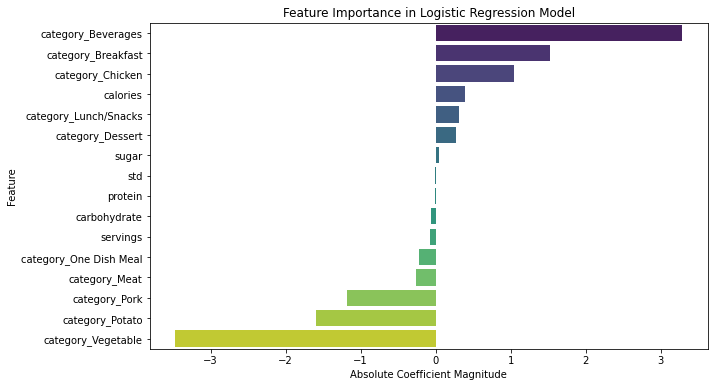

In [123]:
# Feature Importance
importances = pd.Series(best_logistic_model.coef_[0], index=df.drop("traffic", axis=1).columns)
sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index, palette="viridis")
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

In [130]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [ None, 10, 20],
    'min_samples_split': [2, 3, 5],
    'random_state': [42]
}

# Initialize Random Forest model
random_forest_model = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Get the best model from the grid search
best_random_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_random_model.predict(X_test)

# Evaluate the best model
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display results
print("Best Parameters:", best_params)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Best Parameters: {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 50, 'random_state': 42}

Confusion Matrix:
 [[105  12]
 [ 18  44]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       117
           1       0.79      0.71      0.75        62

    accuracy                           0.83       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.83      0.83      0.83       179



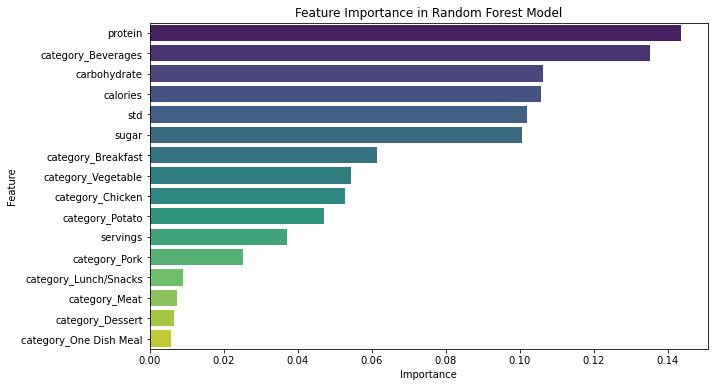

In [131]:
# Feature Importance
importances = pd.Series(best_random_model.feature_importances_, index=df.drop("traffic", axis=1).columns)
sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=sorted_importances.index, x=sorted_importances, palette="viridis")
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Model Evaluation
Both models, Logistic Regression and Random Forest, demonstrate reasonable performance on the test data. Notably, the Random Forest model exhibits higher accuracy on both the training and test sets. This suggests that the Random Forest model is adept at capturing the underlying patterns within the data more effectively than Logistic Regression. The superior performance of the Random Forest model, as indicated by its higher accuracy scores, highlights its potential as a robust classifier for the given task.

In [141]:
from sklearn.metrics import accuracy_score

# accuracy score on the train data
X_train_pred = best_logistic_model.predict(X_train)
logistic_train_accuracy =  accuracy_score(X_train_pred, y_train)
print('Accuracy score of best logistic model on train data: ', logistic_train_accuracy)

# accuracy score on the test data
X_test_pred =best_logistic_model.predict(X_test)
logistic_test_accuracy =  accuracy_score(X_test_pred, y_test)
print('Accuracy score of  best logistic model on test data: ', logistic_test_accuracy)


# accuracy score on the train data
X_train_pred = best_random_model.predict(X_train)
random_train_accuracy =  accuracy_score(X_train_pred, y_train)
print('Accuracy score of best random model on the train data: ', random_train_accuracy)

# accuracy score on the test data
X_test_pred = best_random_model.predict(X_test)
random_test_accuracy =  accuracy_score(X_test_pred, y_test)
print('Accuracy score of best random model on the test data: ', random_test_accuracy)

Accuracy score of best logistic model on train data:  0.7458100558659218
Accuracy score of  best logistic model on test data:  0.8268156424581006
Accuracy score of best random model on the train data:  0.909217877094972
Accuracy score of best random model on the test data:  0.8324022346368715


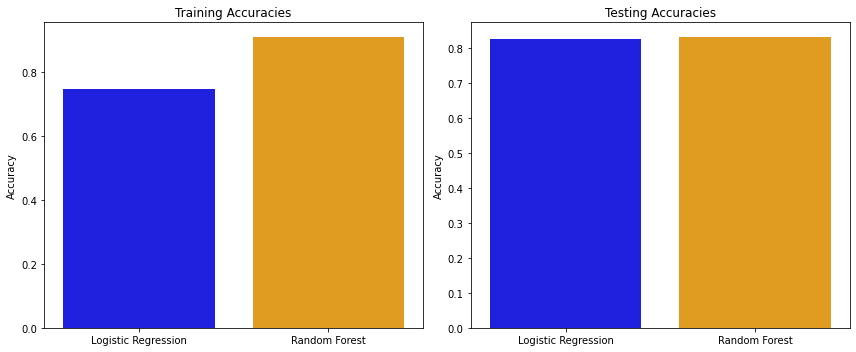

In [142]:
model_names = ['Logistic Regression', 'Random Forest']
accuracies = [[logistic_train_accuracy, random_train_accuracy], 
              [logistic_test_accuracy, random_test_accuracy]]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for i in range(2):
    sns.barplot(x=model_names, y=accuracies[i], ax=axes[i], palette=['blue', 'orange'])
    axes[i].set_ylabel('Accuracy')
    axes[i].set_title('Training Accuracies' if i == 0 else 'Testing Accuracies')

plt.tight_layout()
plt.show()